# Example of block reading

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import HeaderConstants
import FileConstants
import DataExtraction
import DataTypes
import MotionSensorConstants

%reload_ext autoreload
%autoreload 2

In [2]:
# Set to your file path and file name
#folder = '05.09.2022\\16'
folder = '19.09.2022'
file = 'NEUR0040.DF1'
fileName = os.path.join(folder, file)

# Set the following values from event file
# neural
numberOfAdcBits = 16
offset = 2 ** (numberOfAdcBits - 1)
voltageResolution = 1.95e-7
numberOfChannels = 32
neuralSamplingFrequency = 32000
# audio
numberOfAudioBits = 15
audioSamplingFrequency = 100000
isAudioSigned = True
# motion sensor
acclMax = 2*MotionSensorConstants.G  # m/s^2, maximum value of selected range
gyroMax = 250  # degrees per second,  maximum value of selected range
magMax = MotionSensorConstants.MAGNETOMETER_9250_RANGE  # Teslas,  maximum value of selected range

In [3]:
# read data from file as bytes
file = open(fileName, "rb")
byteData = file.read()
file.close()
print(f'File length {len(byteData)} bytes')

File length 16777216 bytes


In [4]:
# check blocks headers are present and report dropped blocks
blockStartIndices = []
droppedBlocks = []
byteData = np.frombuffer(byteData, 'uint8')
lastFilledBlock = DataExtraction.getLastBlockInFile(byteData)
for i in range(0, len(byteData), FileConstants.BLOCK_SIZE):
    thisBlockIdx = i/FileConstants.BLOCK_SIZE
    if thisBlockIdx > lastFilledBlock:
        break
    constId = byteData[i:i+len(HeaderConstants.HEX_CONST_ID)]
    if np.array_equal(constId, HeaderConstants.HEX_CONST_ID):
        blockStartIndices.append(i)
    elif np.array_equal(constId, FileConstants.EMPTY_BYTES_00) or np.array_equal(constId, FileConstants.EMPTY_BYTES_FF):
        droppedBlocks.append(thisBlockIdx)
    else:
        print("Warning: Unexpected values for header constant - file is corrupted")

for i in range(0, len(droppedBlocks)):
    print("Dropped block at block number {}".format(droppedBlocks[i]))


print(f'Good blocks {len(blockStartIndices)} Empty blocks {len(droppedBlocks)}')

Good blocks 256 Empty blocks 0


In [5]:
# extract and parse headers
# get timestamps
timestamps = []
for blockId in range(0, len(blockStartIndices)): #timestamps change in every header
    thisBlockStart = blockStartIndices[blockId]
    header = byteData[thisBlockStart:thisBlockStart + HeaderConstants.HEADER_TOTAL_BYTES]
    thisTimestamp = np.array(header[HeaderConstants.TIME_STAMP_POSITION:HeaderConstants.TIME_STAMP_POSITION +
                    HeaderConstants.TIME_STAMP_BYTES]).view(np.uint32)[0]
    timestamps.append(thisTimestamp)

# Check that they are of the same duration
# %matplotlib widget
# plt.plot(np.diff(np.array(timestamps)))

In [6]:
# extract block structure
# structure of block is same in all blocks so using first header is sufficient
firstHeader = byteData[0:HeaderConstants.HEADER_TOTAL_BYTES]
partitionInfo = np.array(firstHeader[HeaderConstants.PARTITION_START_POSITION:HeaderConstants.PARTITION_START_POSITION + HeaderConstants.PARTITION_BYTES])
dataTypesPresent = []
dataStartIndices = []  # the byte within the block where this type of data starts
dataSegmentLengths = []
partitionIdx = 0
numBytes = 4  # stored as uint32
while (partitionIdx < len(partitionInfo)):
    dataTypesPresent.append(partitionInfo[partitionIdx:partitionIdx + numBytes].view(np.uint32)[0])
    partitionIdx += numBytes
    dataStartIndices.append(partitionInfo[partitionIdx:partitionIdx + numBytes].view(np.uint32)[0])
    partitionIdx += numBytes
    dataSegmentLengths.append(partitionInfo[partitionIdx:partitionIdx + numBytes].view(np.uint32)[0])
    partitionIdx += numBytes

for i in range(int(len(partitionInfo)/(numBytes*3))):
    print(f'Type {dataTypesPresent[i]} Start {dataStartIndices[i]} Len {dataSegmentLengths[i]}')

Type 1 Start 108 Len 300
Type 2 Start 408 Len 63488
Type 3 Start 63896 Len 672
Type 0 Start 0 Len 0
Type 0 Start 0 Len 0
Type 0 Start 0 Len 0
Type 0 Start 0 Len 0


In [7]:
# Extract neural data
IsNeuralPresent = DataTypes.DataType.NEURAL in dataTypesPresent  #check neural data is present
neuralData = []
if IsNeuralPresent:
    neuralBytes = DataExtraction.extractDataSegments(DataTypes.DataType.NEURAL, dataTypesPresent, blockStartIndices, byteData, dataStartIndices, dataSegmentLengths)
    neuralDataArray = DataExtraction.convertNeuralBytes(neuralBytes, voltageResolution, offset)

    for chanId in range(0, numberOfChannels):
        neuralData.append(neuralDataArray[chanId:len(neuralDataArray):numberOfChannels])

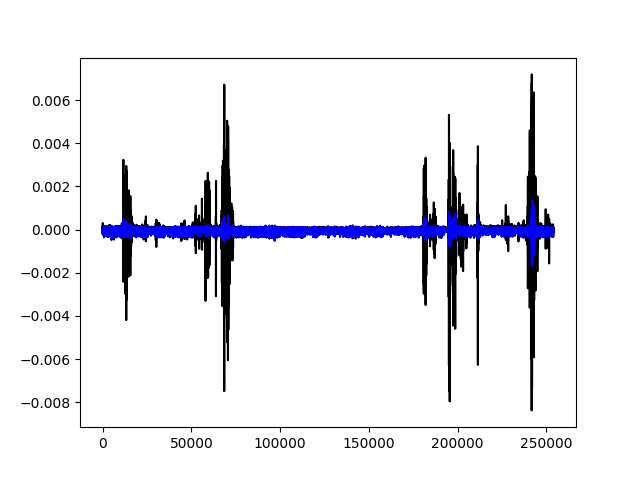

In [11]:
%matplotlib widget

import scipy.signal as sig

def katya_filt(orig_sig):
    [b,a] = sig.butter(4,300/(32000/2),'high')
    f_sig = sig.filtfilt(b, a, orig_sig)
    return f_sig



#plt.plot(katya_filt(neuralData[10]),'k')
#plt.plot(katya_filt(neuralData[10]-k),'b')
plt.plot(katya_filt(neuralData[10]),'k')
plt.plot(katya_filt(neuralData[10]-k),'b')



In [9]:
k = neuralData[0].copy()
for i in range(1,11):
    k += neuralData[i]
k /= 11


In [34]:
i

10

In [24]:
# Extract motion sensor data
IsMotionSensorPresent = DataTypes.DataType.MOTIONSENSOR in dataTypesPresent
if IsMotionSensorPresent:
    # get motion sensor bytes from file
    motionSensorBytes = DataExtraction.extractDataSegments(DataTypes.DataType.MOTIONSENSOR,
                       dataTypesPresent,blockStartIndices, byteData, dataStartIndices,
                       dataSegmentLengths)
    # convert to uint16
    motionSensorInts = np.array(motionSensorBytes).view(np.int16)
    # find block starts
    msStartBlockIndices = DataExtraction.extractMotionSensorBlockStarts(motionSensorInts,
                                           MotionSensorConstants.CONST_ID)
    # get motion sensor timestamp of each block
    motionSensorTimestamps = DataExtraction.extractMotionSensorTimestamps(motionSensorInts, msStartBlockIndices )
    # sort into accelerometer, gyro and magnetometer
    accelerometerInts, gyroscopeInts, magnetometerInts = DataExtraction.extractMotionSensor(
        motionSensorInts, msStartBlockIndices)

    # convert to physical units
    accelerometerData = DataExtraction.convertMotionSensorData(accelerometerInts,
                       MotionSensorConstants.ACCELEROMETER_NUMBER_OF_BITS, acclMax)
    gyroscopeData = DataExtraction.convertMotionSensorData(gyroscopeInts,
                       MotionSensorConstants.GYROSCOPE_NUMBER_OF_BITS, gyroMax)
    magnetometerData = DataExtraction.convertMotionSensorData(magnetometerInts,
                       MotionSensorConstants.MAGNETOMETER_NUMBER_OF_BITS, magMax)


    # sort data by axes
    xAccelerometer, yAccelerometer, zAccelerometer = DataExtraction.sortMotionSensorByAxes(
        accelerometerData, MotionSensorConstants.NUMBER_OF_AXES)
    xGyroscope, yGyroscope, zGyroscope = DataExtraction.sortMotionSensorByAxes(
        gyroscopeData, MotionSensorConstants.NUMBER_OF_AXES)
    xMagnetometer, yMagnetometer, zMagnetometer = DataExtraction.sortMotionSensorByAxes(
        magnetometerData, MotionSensorConstants.NUMBER_OF_AXES)


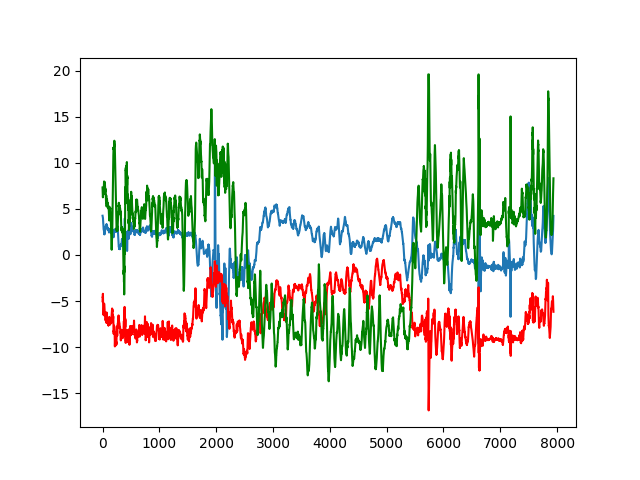

In [50]:
%matplotlib widget
plt.plot(xAccelerometer)
plt.plot(yAccelerometer,'r')
plt.plot(zAccelerometer,'g')


In [63]:
motionSensorTimestamps

array([42373632., 42373653., 42373684., 42373715., 42373745., 42373777.,
       42373808., 42373839., 42373870., 42373901., 42373932., 42373963.,
       42373994., 42374025., 42374056., 42374087., 42374118., 42374149.,
       42374180., 42374211., 42374242., 42374273., 42374304., 42374335.,
       42374366., 42374397., 42374428., 42374459., 42374490., 42374521.,
       42374552., 42374583., 42374614., 42374645., 42374676., 42374707.,
       42374738., 42374769., 42374800., 42374831., 42374862., 42374893.,
       42374923., 42374955., 42374986., 42375017., 42375048., 42375080.,
       42375110., 42375141., 42375172., 42375202., 42375234., 42375265.,
       42375296., 42375327., 42375359., 42375389., 42375420., 42375451.,
       42375481., 42375513., 42375544., 42375575., 42375606., 42375637.,
       42375668., 42375699., 42375730., 42375761., 42375792., 42375823.,
       42375854., 42375885., 42375916., 42375947., 42375978., 42376009.,
       42376040., 42376071., 42376102., 42376133., 

In [68]:
acc['x']

NameError: name 'acc' is not defined